# AgCaP
<br>

**Conceptualization, Methodology:** [Davide Mazzoni](https://github.com/orgs/SEforALL-IEAP/people/davidemazzoni2) <br> **Code:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br> **Supervision, Review and Advisory support:** xx<br> **Funding:** SeforALL

--------------------------
This is the AgCap notebook.The main purpose of this notebook is to .... Using this notebook the user will be able to change however many datasets needed.

In order to run the analysis the following datasets are needed:
* [Population clusters (settlements)](https://data.grid3.org/datasets/GRID3::grid3-moz-settlement-extents-v2-0/explore) 
* [Population](https://data.humdata.org/dataset/gridded-population-estimates-for-mozambique-2017-census-v1-1?)  
* [Cropland extent](https://glad.umd.edu/dataset/croplands) 
* [Livelihood zones](https://fews.net/mozambique-livelihood-zones-2014) 
* [Food insecurity](https://fews.net/data/acute-food-insecurity?field_data_node_dates_end_value=&date=&region%5B%5D=547) 
* [Satellite nightlights](https://eogdata.mines.edu/products/vnl/) 
* [Coastline](https://www.soest.hawaii.edu/pwessel/gshhg/) 
* [Railway stations](OSM extraction) 
* [Airports](OSM extraction)
* [Ports](OSM extraction)
* [Security risk (conflicts)](https://acleddata.com/data-export-tool/)
* Drought risk
* Flood risk
* Heat waves risk
* Road network
* [Water frequency](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater)
* [Livestock](https://dataverse.harvard.edu/dataverse/glw_4)
* [Admin boundaries](https://gadm.org/)
* [Air temperature at 2m (dry bulb)](https://solargis.com/maps-and-gis-data/download)

Below instructions for each cell follows.


## Importing necessary packages (Mandatory)

Packages to be used are imported from the funcs.ipynb.

In [1]:
from ipynb.fs.full.funcs import *

C:\Users\alexl\Dropbox\Self-employment\SEforALL\Work\Mozambique\Cooling_Module\funcs.ipynb:733: SyntaxWarning: "is" with a literal. Did you mean "=="?
  },
C:\Users\alexl\Dropbox\Self-employment\SEforALL\Work\Mozambique\Cooling_Module\funcs.ipynb:735: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "cell_type": "code",


In [2]:
## Import python modules
#import geopandas as gpd
#import pandas as pd
#import pyproj
#import numpy as np
#
#from functools import reduce
#import shapely
#from shapely.geometry import Point, Polygon, MultiPoint
#from shapely.ops import nearest_points
#
#from sklearn.neighbors import BallTree
#
##import datapane as dp
##!datapane login --token=9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8
#
#import folium
#from folium.features import GeoJsonTooltip
#folium.__version__ = '0.12.0'                 ## Had to manually set the version as not available when package installed
#import branca.colormap as cm
#import os
#from IPython.display import display, Markdown, HTML, FileLink, FileLinks

import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator

#import datetime

#%matplotlib inline

## Setting the target coordinate system (Mandatory)

When calculating distances it is important to choose a coordinate system that represents distances correctly in your area of interst. The coordinate system that is given below is the World Mercator, these coordinate system works well for Sub Saharan Africa but the distortions get larger as you move away from the equator.

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the "EPSG" part)**.

**NOTE** When selecting your coordinate system make sure that you select a system with the unit of meters, this is indicated for all systems on [epsg.io](http://epsg.io/)

In [3]:
## Coordinate and projection systems
crs_WGS84 = pyproj.CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = pyproj.CRS("EPSG:32637")    # Projection system for the selected country -- see http://epsg.io/ for more info

## Define workspace and main directories

Define the workspace. The output layers will populate this folder. It is highly recommended to select an empty folder as your workspace.

In [4]:
ROOT_DIR = os.path.abspath(os.getcwd())
in_path = ROOT_DIR + "\\" + 'GIS_data'
workspace = ROOT_DIR + "\\" + "Output"

In [5]:
#messagebox.showinfo('Cooling module', 'Output folder')
#workspace = filedialog.askdirectory()

## Importing admin boundary as geodataframe
For the administrative boundaries you will have to select an **Polygon** layer represeting your area of interest.

In [8]:
# Define path and name of the file
admin_path = in_path + "\\" + "Admin"
admin_name = "moz_admin1.gpkg"

In [9]:
# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)
test_admin_gdf = gpd.read_file(admin_path + "\\" + admin_name) ### This is just for the test case study (MV and TRX extraction)
##Activate this if you want to clip part of the AoI e.g., for testing
admin_gdf = admin_gdf[admin_gdf.ADM2_NAME == "Mopeia"]


## Add buffer for clipping
## cap_style refers to the type of geometry generated; 3=rectangular (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)
admin_gdf_buf = admin_gdf.copy()
admin_gdf_buf['geometry'] = admin_gdf_buf.apply(lambda x:
                                        x.geometry.buffer(0.008, cap_style=3), axis=1)  ### 0.008 deg = ~1km

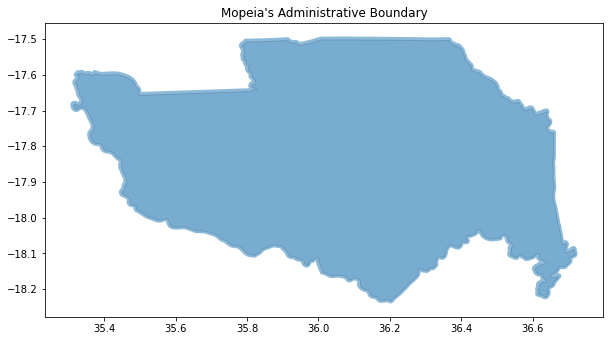

In [10]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
admin_gdf_buf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

## Define the target locations (settlements/clusters)

Select the settlements to be used in the analysis

In [14]:
# Define path and name of the file
settles_path = in_path + "\\" + "Settlements"
#settles_name = "Mozambique_Settlement_Extents_Version_02.geojson"
settles_name = "Mopeia_clusters.shp"

In [15]:
## Read settlements as gdf
settles_gdf = gpd.read_file(settles_path + "\\" + settles_name)

In [16]:
##Activate this if you want to clip part of the AoI e.g., for testing
settles_gdf  = gpd.clip(settles_gdf, admin_gdf_buf)

### Filter clusters based on Building Count
Keeping clusters with more than 100 buildings

In [17]:
#settles_gdf.dtypes
settles_gdf["bld_count"].unique()

array(['251-1000', '101-250', '1001 and up'], dtype=object)

In [18]:
## If building count is an object you can use his to filter
settles_gdf = settles_gdf[(settles_gdf["bld_count"] == '101-250') | 
                          (settles_gdf["bld_count"] == '251-1000') | 
                          (settles_gdf["bld_count"] == '1001 and up')]

#If building count is numeric you can use his to filter
#settles_gdf = settles_gdf[settles_gdf["bld_count"] >= 100]

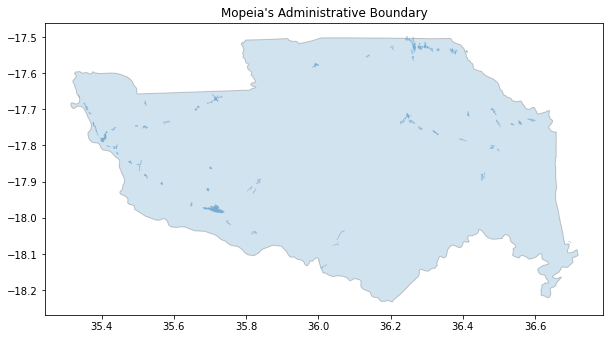

In [19]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

### Raster population to clusters

In [20]:
settles_gdf = processing_raster("population", "sum", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-03-23 21:50:29.062071
2024-03-23 21:50:29.726011


### Extracting RWI to clusters

Note that you can rasterize the csv file (as from HDX source) using the relevant .ipynb in the repo

In [21]:
settles_gdf = processing_raster("RWI", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-03-23 21:50:39.239126
2024-03-23 21:50:39.932196


### Extracting animal headcount to clusters

In [22]:
animal_type = ["cattle", "chickens", "ducks", "goats", "pigs", "sheep", "horses", "buffaloes"]

In [23]:
for animal in animal_type:
    settles_gdf = processing_raster(animal, "sum", settles_gdf)
    
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-03-23 21:50:58.570351
2024-03-23 21:51:02.210732
2024-03-23 21:51:05.623224
2024-03-23 21:51:08.866304
2024-03-23 21:51:12.416464
2024-03-23 21:51:15.858232
2024-03-23 21:51:18.823636
2024-03-23 21:51:22.020241
2024-03-23 21:51:22.713167


### Extracting HREA lightscore values to clusters

In [24]:
## Getting the average annual composite from VIIRS
settles_gdf = processing_raster("VIIRS", "mean" , settles_gdf)

## Extracting the max probability (lisghtscore) from the HREA layer
settles_gdf = processing_raster("HREA_lightscore", "max" , settles_gdf)

settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-03-23 21:51:39.152707
2024-03-23 21:51:42.872127
2024-03-23 21:51:43.556395


### Get accessibility

------------------------------------

**THIS IS WORK IN PROGRESS** --> For now we assume that the accessibility maps are already available via other methods

------------------------------------

**Note!** Accessibility maps can be retrieved using the other notebookes in this repository. More specifically:
* "Travel_time_maps.ipynb" will prepare the vector data as needed for
* "R-tool.ipynb", which prepares uses the [motorized friction surface layer](https://malariaatlas.org/project-resources/accessibility-to-healthcare/) and generates travel time maps for the locations of airports, ports, railways, major cities and the capital located in the "key_locations_for_Distance directory".

The above notebooks are preparatory and should be run before running this current .ipynb.

In [25]:
settles_gdf = processing_raster("access_airports", "mean", settles_gdf)
settles_gdf = processing_raster("access_ports", "mean", settles_gdf)
settles_gdf = processing_raster("access_railways", "mean", settles_gdf)
settles_gdf = processing_raster("access_cities", "mean", settles_gdf)
settles_gdf = processing_raster("access_capital", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)

2024-03-23 21:52:12.572811
2024-03-23 21:52:19.892836
2024-03-23 21:52:24.305962
2024-03-23 21:52:27.655784
2024-03-23 21:52:31.971154
2024-03-23 21:52:32.656092


In [26]:
## Converting min to hours
settles_gdf['access_airportsmean'] = settles_gdf['access_airportsmean']/60
settles_gdf['access_portsmean'] = settles_gdf['access_portsmean']/60
settles_gdf['access_railwaysmean'] = settles_gdf['access_railwaysmean']/60
settles_gdf['access_citiesmean'] = settles_gdf['access_citiesmean']/60
settles_gdf['access_capitalmean'] = settles_gdf['access_capitalmean']/60

### Estimating Cooling requirements

In [27]:
settles_gdf = processing_raster("avg_temp", "mean", settles_gdf)
settles_gdf = finalizing_rasters(workspace, settles_gdf, crs_WGS84)
settles_gdf["CDD"] = (settles_gdf["avg_tempmean"] - 4)*365

2024-03-23 21:52:51.464943
2024-03-23 21:52:52.154505


### Fishing activity

In [28]:
## Adding a 10km buffer to the settlements layer
settles_gdf_buf = settles_gdf.copy()
settles_gdf_buf_prj = settles_gdf_buf.to_crs(crs_proj)
settles_gdf_buf_prj['geometry'] = settles_gdf_buf_prj.apply(lambda x:
                                                            x.geometry.buffer(10000, cap_style=3), axis=1)  ### ~10000m#
settles_gdf_buf = settles_gdf_buf_prj.to_crs(crs_WGS84)

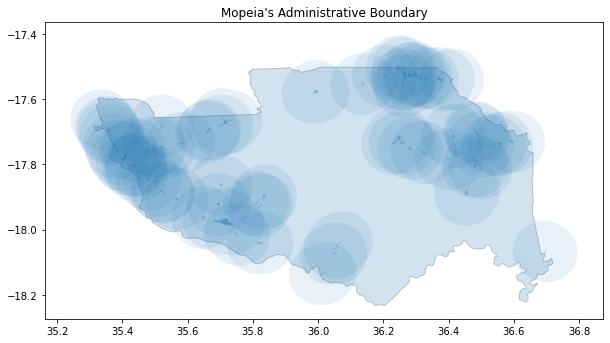

In [29]:
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
settles_gdf_buf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.1)
ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

#### Reclassifying raster 

In [30]:
WOraster = in_path + "\\" + "Water_Occurance" + "\\" + "Surface_Water_Occurance_2021_Mopeia.tif"
WOrasterreclass = in_path + "\\" + "Water_Occurance" + "\\" + "Surface_Water_Occurance_2021_Mopeia_reclass.tif"

In [31]:
## Reading the water occurance layer and reclasifying it keeping only values higher than 85 units
with rasterio.open(WOraster) as src:    
    # Read as numpy array
    array = src.read()
    profile = src.profile

    # Reclassify
    array[np.where(array <= 85)] = 0 
    #array[np.where(array == 2)] = 1
    # and so on ...  

with rasterio.open(WOrasterreclass, 'w', **profile) as dst:
    # Write to disk
    dst.write(array)

#### Extracting values to raster | merging with original settlements layer

In [32]:
settles_gdf_buf = processing_raster("water_occur", "sum", settles_gdf_buf)
settles_gdf_buf = finalizing_rasters(workspace, settles_gdf_buf, crs_WGS84)
settles_gdf = settles_gdf.merge(settles_gdf_buf[["id", 'water_occursum']], how="left", on='id')
settles_gdf['water_occursum'].fillna(0, inplace=True)

2024-03-23 21:53:26.298639
2024-03-23 21:53:26.429128


#### Classification of water occurrence values

In [33]:
## Binary classification of occurence values
settles_gdf['Water_Occur_Bin'] = settles_gdf['water_occursum'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Qualitative classification based on quantiles
num_classes = 4
quantiles = np.linspace(0, 1, num_classes + 1)
quantile_values = settles_gdf['water_occursum'].quantile(quantiles)

def classify_occurrence(value, quantile_values):
    if value == 0:
        return 'No Occurrence'
    elif value <= quantile_values[0.25]:
        return 'Low Occurrence'
    elif value <= quantile_values[0.75]:
        return 'Medium Occurrence'
    else:
        return 'High Occurrence'

settles_gdf['Water_Occur_Clas'] = settles_gdf['water_occursum'].apply(classify_occurrence, args=(quantile_values,))

### Shorelines

In [34]:
# Define path and name of the file -- Using Resolution "f" and Level 1 as in documentation (here: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/)--
shores_path = in_path + "\\" + "Shoreline"
shores_name = "Moz_Shoreline.gpkg"

In [35]:
## Read shores as gdf
shores_gdf = gpd.read_file(shores_path + "\\" + shores_name)

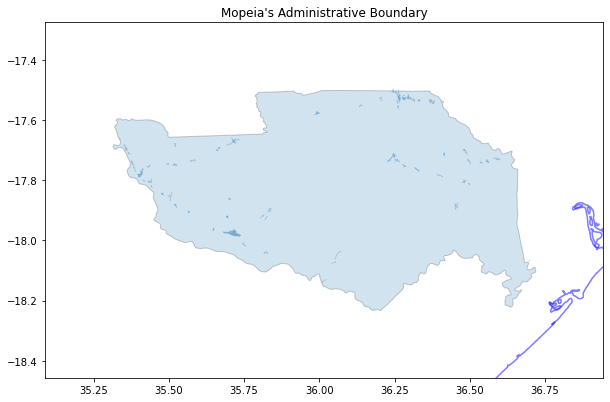

In [36]:
##Vizualize the shoreline in respect to the AoI
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))
# Get the bounding box
xmin, ymin, xmax, ymax = admin_gdf.total_bounds
# Add a 50km buffer
buffer_size = 25  # in kilometers
# Convert buffer size from kilometers to degrees (assuming a spherical Earth)
buffer_degrees = buffer_size / 111.32  # Approximately 111.32 kilometers per degree at the equator
# Adjust the bounding box coordinates
xmin -= buffer_degrees
ymin -= buffer_degrees
xmax += buffer_degrees
ymax += buffer_degrees

admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
settles_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5)
shores_gdf.plot(ax=ax, legend=True, markersize=3, figsize=(15, 15), alpha=0.5, edgecolor='blue', facecolor='none')

# Set the limits to zoom in on the specified bounding box
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect('equal', 'box')
txt = ax.set_title("{}'s Administrative Boundary".format(admin_gdf.ADM2_NAME.unique()[0]))

In [37]:
settles_gdf = preparing_for_vectors_updated(workspace, settles_gdf, crs_proj)

2024-03-23 21:53:40.071643


In [38]:
settles_gdf = processing_shorelines("Shoreline", shores_gdf, crs_proj, workspace, settles_gdf)

2024-03-23 21:54:10.526205


In [39]:
## Binary classification of occurence values
settles_gdf['ShoreWithin10km'] = settles_gdf['ShorelineDist'].apply(lambda x: 'Yes' if x < 10 else 'No')

### Getting distance to nearest MV line

In [40]:
settles_gdf = processing_lines("MV_lines", admin_gdf, crs_proj, workspace, settles_gdf)

2024-03-23 21:54:34.238969


### Getting distance to nearest Service Transformer (TRX)

In [41]:
settles_gdf = processing_points("TRX", test_admin_gdf, crs_proj, workspace, settles_gdf, False)

2024-03-23 21:54:53.400479


### Electrification status classification 

In [42]:
TRX_dist_thres1 = 0.5
TRX_dist_thres2 = 1
MV_dist_thres1 = 0.5
MV_dist_thres2 = 1
mean_light_thres1 = 0.6
mean_light_thres2 = 0.4
mean_lightprob_thres1 = 0.8
mean_lightprob_thres2 = 0.5


def assign_elec_status(row):
    if (row["TRXDist"] < TRX_dist_thres1) and (row["MV_linesDist"] < MV_dist_thres1) and (row["VIRRSmean"] > mean_light_thres1) and (row["HREA_lightscoremax"] > mean_lightprob_thres1):
        return "electrified"
    elif (row["TRXDist"] < TRX_dist_thres2) and (row["MV_linesDist"] < MV_dist_thres2) and (row["VIRRSmean"] > mean_light_thres2) and (row["HREA_lightscoremax"] > mean_lightprob_thres2):
        return "likely electrified"
    else:
        return "un-electrified"
    
# Apply the function row-wise
settles_gdf["elec_status"] = settles_gdf.apply(assign_elec_status, axis=1)

### Food security

In [43]:
food_path = in_path + "\\" + "Food_Security"
food_name = "food_insecurity_IPC_May23_Mar24.gpkg"
food_gdf = gpd.read_file(food_path + "\\" + food_name)

In [44]:
food_gdf = cleaning_string_attributes(food_gdf, "area")

In [45]:
# Convert the DataFrame to a dictionary
food_sec_dict = {key: value for key, value in zip(food_gdf['area'], food_gdf['phase3_C_percentage'])}

In [46]:
settles_gdf = get_admin_name(settles_gdf, test_admin_gdf, "ADM2_NAME")

2024-03-23 21:55:00.904426


In [47]:
settles_gdf['Food_Sec'] = settles_gdf['ADM2_NAME'].map(food_sec_dict)

## Create Voronoi Polygons around settlements

Boundary area defined..
Perimeter vertices generated..
Voronoi polygons generated..
Dissolved Voronoi polygons completed..
Vizualizing...


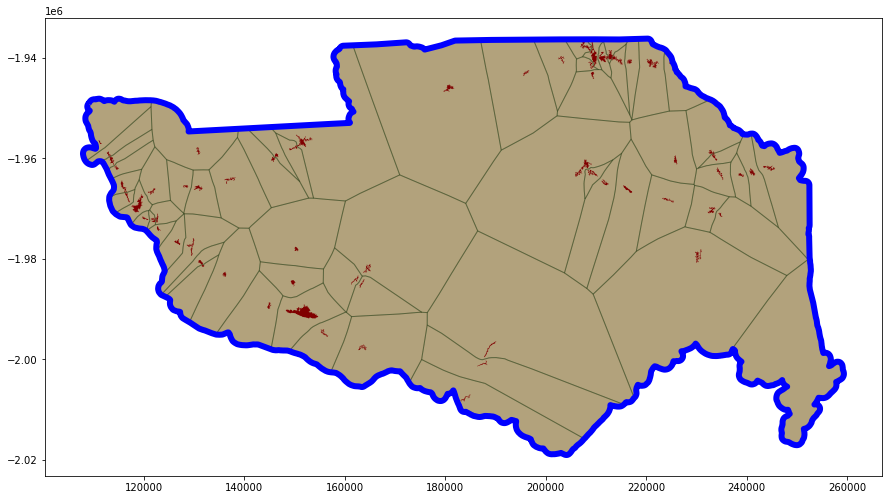

In [50]:
vor_poly = createVoronoi(admin_gdf_buf, settles_gdf, crs_proj, crs_WGS84)

In [51]:
#vor_poly = vor_poly.drop('Crop%', axis=1)

### Extracting Cropland extent

In [55]:
# Define path and name of the file
in_path_raster = in_path + "\\" + "Cropland"
cropland_name = "Global_cropland_SE_2019_Mopeia.tif"

In [56]:
# Calling the extraction function for discrete layers
vor_poly = processing_raster_cat(in_path_raster, cropland_name, "cropland", vor_poly)
vor_poly = finalizing_rasters(workspace, vor_poly, crs_proj)

cropland processing completed at 2024-03-23 22:09:25.183012
2024-03-23 22:09:25.331017


In [57]:
# Identify land cover related columns
final_list_of_cols = list(vor_poly.columns)
crop_cols = []
for col in final_list_of_cols:
    if "cropland" in col:
        crop_cols.append(col)
if not crop_cols:
    print ("There is not any Land Cover associated column in the dataframe; please revise")
else:
    pass

In [58]:
vor_poly = calc_Crop_sqkm(vor_poly, crop_cols)
vor_poly.rename({'cropland0':'No_crop_ha', 'cropland1':'Cropland_ha'}, axis=1, inplace=True)
vor_poly["Crop%"] = vor_poly['Cropland_ha']/vor_poly['Vor_area_ha']*100

In [59]:
vor_poly

,id,Vor_area_ha,Vor_area_sq.km,uniqueID,No_crop_ha,Cropland_ha,geometry,Crop%
0,420329,3370.888402,33.708884,69,3149.567446,221.320956,"POLYGON ((35.47006 -17.88445, 35.45013 -17.904...",6.565657
1,420504,1447.923169,14.479232,68,1326.621765,121.301405,"POLYGON ((35.46500 -17.82864, 35.46246 -17.831...",8.377613
2,421423,8175.687214,81.756872,384,8041.939738,133.747476,"POLYGON ((35.45013 -17.90497, 35.47006 -17.884...",1.635917
3,422404,3824.256977,38.242570,3232,3692.181527,132.075451,"POLYGON ((35.32956 -17.69939, 35.32710 -17.700...",3.453624
4,423418,2283.509379,22.835094,3198,2207.040572,76.468808,"MULTIPOLYGON (((35.36786 -17.70109, 35.36698 -...",3.348741
...,...,...,...,...,...,...,...,...
61,512919,4615.067886,46.150679,296,4611.947194,3.120692,"POLYGON ((36.48181 -17.60520, 36.46257 -17.613...",0.067620
62,512991,2737.154059,27.371541,8524,2736.071038,1.083021,"POLYGON ((36.32987 -17.62220, 36.33050 -17.631...",0.039567
63,513337,10140.299100,101.402991,1031,8798.285341,1342.013759,"POLYGON ((35.70632 -18.02192, 35.68469 -18.045...",13.234459
64,602105,14952.905333,149.529053,1182,14840.376645,112.528688,"POLYGON ((36.66423 -17.89400, 36.66097 -17.894...",0.752554


### Extracting harvested area

Here we are using a few sample crops, which of course can be expanded based on case study/need..

In [60]:
crop_types = ["rice", "maize", "cassava", "sorghum"]

In [61]:
for crop in crop_types:
    vor_poly = processing_raster(crop, "sum", vor_poly)
    
vor_poly = finalizing_rasters(workspace, vor_poly, crs_WGS84)

2024-03-23 22:09:42.803821
2024-03-23 22:09:48.494319
2024-03-23 22:09:53.724633
2024-03-23 22:09:57.520582
2024-03-23 22:09:57.708692


## Merging Voronoi to clusters

In [62]:
settles_gdf = settles_gdf.merge(vor_poly[['id',
                                          'Crop%', 
                                          'Cropland_ha', 
                                          'No_crop_ha', 
                                          'Vor_area_ha', 
                                          'Vor_area_sq.km',
                                          'ricesum', 
                                          'maizesum', 
                                          'cassavasum', 
                                          'sorghumsum']], how="left", on='id')

# TBD..